In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


#1.1 Create the Dataset and Split it into Training and Validation Sets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset"

train_dataset = image_dataset_from_directory("dataset/training", 
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42
                                            )

test_data = image_dataset_from_directory("dataset/test",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        validation_split=0.2,
                                        subset='validation',
                                        seed=42
                                        )

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 400 files belonging to 2 classes.
Using 80 files for validation.


2022-05-31 10:54:38.894892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


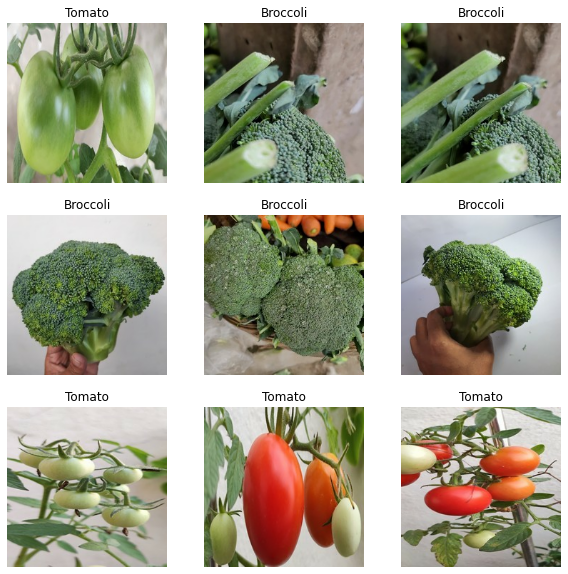

In [2]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [3]:
# Using prefetch() prevents a memory bottleneck that can occur when reading from disk. 

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [4]:
# Augmenting the data

# def data_augmenter():
#     data_augmentation = tf.keras.Sequential([
#         tfl.experimental.preprocessing.RandomFlip("horizontal"),
#         tfl.experimental.preprocessing.RandomRotation(0.2),
#     ])
#     return data_augmentation

# augmenter = data_augmenter()

# "First layer must be RandomFlip"
# assert(augmenter.layers[0].name.startswith('random_flip'))
# "RadomFlip parameter must be horizontal"
# assert augmenter.layers[0].mode == 'horizontal'
# "Second layer must be RandomRotation"
# assert(augmenter.layers[1].name.startswith('random_rotation'))
# "Rotation factor must be 0.2"
# assert augmenter.layers[1].factor == 0.2

# print('\033[92mAll tests passed!')
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])



NameError: name 'augmenter' is not defined

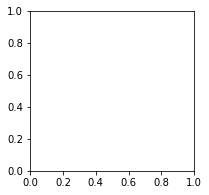

In [5]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [6]:
# Using a pre-trained model that was trained on the 
# normalization values [-1, 1], it's best practice to reuse 
# that standard with tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


# This layer is called the "bottleneck layer".
# The bottleneck layer features retain more generality as compared to the final/top layer.

In [7]:
# Using MobileNetV2 for Transfer Learning






IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [9]:
# Top layers are responsible for classification

# nb_layers = len(base_model.layers)
# print(nb_layers)
# print(base_model.layers[nb_layers - 2].name)
# print(base_model.layers[nb_layers - 1].name)

# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
# # Taking the first batch from the tensorflow dataset to use the images,
# # and run it through the MobileNetV2 base model to test out the predictions on some 
# # of your images.

# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [11]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)>

In [12]:
# Important note about BatchNormalization layers
# Many models contain tf.keras.layers.BatchNormalization layers. 
# This layer is a special case and precautions should be taken in the context of fine-tuning
# When you set layer.trainable = False, 
# the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

# To generate predictions from the block of features, average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert
# the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. 
# You don't need an activation function here because this prediction will be treated as a logit, 
# or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor 
# layers using the Keras Functional API. 
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.


inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



In [15]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
len(model.trainable_variables)

158

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_data)

3/3 [==============================] - 2s 236ms/step - loss: 0.6110 - accuracy: 0.6750


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.68


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_data)


Epoch 1/10
50/50 [==============================] - 59s 1s/step - loss: 6.8976 - accuracy: 0.4844 - val_loss: 1.3020 - val_accuracy: 0.4625
Epoch 2/10
50/50 [==============================] - 50s 1s/step - loss: 1.7011 - accuracy: 0.4812 - val_loss: 1.5653 - val_accuracy: 0.5375
Epoch 3/10
50/50 [==============================] - 50s 994ms/step - loss: 1.4524 - accuracy: 0.4931 - val_loss: 1.3304 - val_accuracy: 0.5375
Epoch 4/10
50/50 [==============================] - 49s 988ms/step - loss: 1.4928 - accuracy: 0.4863 - val_loss: 0.9889 - val_accuracy: 0.5375
Epoch 5/10
50/50 [==============================] - 50s 995ms/step - loss: 1.5675 - accuracy: 0.4881 - val_loss: 1.6265 - val_accuracy: 0.5375
Epoch 6/10
50/50 [==============================] - 51s 1s/step - loss: 1.3706 - accuracy: 0.4969 - val_loss: 0.9210 - val_accuracy: 0.5375
Epoch 7/10
50/50 [==============================] - 50s 991ms/step - loss: 1.3498 - accuracy: 0.4919 - val_loss: 1.6690 - val_accuracy: 0.5375
Epoch 8/

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

In [ ]:
# Advocado_model

def advocado_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
   
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
                                                   include_top=False, 
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(.2)(x)
    prediction_layer = tf.keras.layers.Dense(1)
    
    # YOUR CODE ENDS HERE
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model


model2 = advocado_model(IMG_SIZE, augmenter)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
# Training the model
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])
epochs = 5
history = model2.fit(normalized_ds, validation_data=test_data, epochs=epochs)

In [ ]:
# Plot the training and validation accuracy

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

print('Number of layers in the base model: ', len(base_model.layers))

fine_tune_at = 120

for layer in base_model.layers[: fine_tune_at]:
    layer.trainable = False
    
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics = ['accuracy']

model2.compile(loss=loss_function,
               optimizer = optimizer,
               metrics = metrics)


In [ ]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

In [ ]:
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data=test_data)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1, epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()